# Image captioning with visual attention

## Creating Data Structure

In [ ]:
!mkdir data
%cd data
!mkdir raw external processed
!mkdir processed/train processed/test

In [ ]:
!apt-get -qq install tree

In [3]:
!tree .

.
├── external
├── processed
│   ├── test
│   └── train
└── raw

5 directories, 0 files


## Downloading Data



In [4]:
!wget -q http://13.234.225.243:9600/train_data.tar -O external/train_data.tar

In [5]:
!wget -q http://13.234.225.243:9600/test_data.tar -O external/test_data.tar 

In [6]:
!tar -xf external/train_data.tar -C raw/

In [7]:
!tar -xf external/test_data.tar -C raw/

In [8]:
!wget -q http://13.234.225.243:9600/train_data.csv -O raw/train_data/train_data.csv

In [9]:
!wget -q http://13.234.225.243:9600/sample_submission.csv -O raw/test_data/sample_submission.csv

### Utility Functions

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf


def plot_grid(files, labels=None, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    random_indexes = random.sample(range(len(files)), k=h*w)
    for i, j in enumerate(random_indexes):
        image = tf.io.read_file(files[j])
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        label = labels[j]

        ax[i // h, i % w].imshow(image)
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(label)
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

## Extract DateField

In [112]:
from glob import glob

import cv2 as cv
import numpy as np
from tqdm.notebook import tqdm


class ExtractRectangle:
    def __init__(self):
        super().__init__()

        self.minLinLength_h = 70
        self.minLinLength_v = 5
        self.maxLineGap = 20

    def is_horizontal(self, line, thresh=5):
        return abs(line[1] - line[3]) <= thresh

    def is_vertical(self, line, thresh=5):
        return abs(line[0] - line[2]) <= thresh

    def get_lines(self, canny, horizontal=True):
        lines = []
        if horizontal:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_h,
                maxLineGap=20,
            )
        else:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_v,
                maxLineGap=20,
            )
        if linesP is not None:
            for i in range(0, len(linesP)):
                l = linesP[i][0]
                if self.is_horizontal(l, 3) and horizontal:
                    lines.append(l)
                elif self.is_vertical(l, 3):
                    lines.append(l)
        return lines

    def remove_whitespace(self, img):
        # https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
        morphed = cv.morphologyEx(threshed, cv.MORPH_CLOSE, kernel)

        cnts = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv.contourArea)[-1]

        x, y, w, h = cv.boundingRect(cnt)
        dst = img[y : y + h, x : x + w]
        return dst

    def process_image(self, filename, path):
        errenous = False
        img = cv.imread(cv.samples.findFile(filename))
        img = self.remove_whitespace(img)
        cImage = np.copy(img)

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        canny = cv.Canny(gray, 100, 200)

        horizontal_lines = self.get_lines(canny)
        horizontal_lines = sorted(horizontal_lines, key=lambda a_entry: a_entry[..., 1])

        vertical_lines = self.get_lines(canny, horizontal=False)
        vertical_lines = sorted(vertical_lines, key=lambda a_entry: a_entry[..., 0])

        if len(horizontal_lines) > 0:
            initial_line = horizontal_lines[0]
            final_line = horizontal_lines[-1]

            # LeftTop(x1, y1) -> RightTop(x2, y1) -> RightBottom(x2, y2) -> LeftBottom(x1, y2)
            y1 = initial_line[1]
            y2 = final_line[1]
            bottom = min(y1, y2)
            top = max(y1, y2)

            # post whitespace removal, dates should only be the major component
            if (top - bottom) / img.shape[0] < 0.6:
                errenous = True
        else:
            errenous = True

        if len(vertical_lines) > 0:
            initial_line = vertical_lines[0]
            final_line = vertical_lines[-1]

            x1 = initial_line[0]
            x2 = final_line[0]
            left = min(x1, x2)
            right = max(x1, x2)

            # as dates occupy majority of the horizontal space
            if (right - left) / img.shape[1] < 0.9:
                errenous = True
        else:
            errenous = True

        if not errenous:
            # cImage = cv.rectangle(cImage, (left, bottom), (right, top), (255, 0, 0), 2)
            cImage = cImage[
                bottom : bottom + (top - bottom), left : left + (right - left)
            ]
        cv.imwrite(f"{path}/{filename.split('/')[-1]}", cImage)

In [12]:
extract = ExtractRectangle()
test_files = glob("raw/test_data/*.png")
test_path = "processed/test/"
for path in tqdm(test_files):
    extract.process_image(path, test_path)

train_files = glob("raw/train_data/*.png")
train_path = "processed/train/"
for path in tqdm(train_files):
    extract.process_image(path, train_path)

100%|██████████| 10000/10000 [01:34<00:00, 106.20it/s]


## Image Captioning

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import collections
import json
import os
import pickle
from pprint import pprint
import random
import requests
import re
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

In [15]:
TEST_IMAGES_PATH = "processed/test/"
TRAIN_CSV_PATH = "raw/train_data/train_data.csv"
TRAIN_IMAGES_PATH = "processed/train/"
RANDOM_STATE = 42
BATCH_SIZE = 64

In [16]:
PUBLIC_host = "http://13.234.225.243"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"
DATA_URL = PUBLIC_host + ":9600"
TAG = "image_captioning_v1"

In [17]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"


seed_everything(RANDOM_STATE)

### Prepare Dataset

In [18]:
train_df = pd.read_csv(TRAIN_CSV_PATH).sort_values(by="tag")

In [19]:
train_df["length"] = train_df["label"].astype(str).str.len()

In [20]:
train_df = train_df.loc[train_df["length"]==8]

In [21]:
image_paths = train_df["tag"].apply(lambda x: TRAIN_IMAGES_PATH+f"{x}.png").tolist()
labels = train_df["label"].apply(lambda x: f"<start> {' '.join(str(x))} <end>").tolist()

In [22]:
orig_labels = train_df["label"].astype(str).tolist()

In [23]:
len(image_paths), len(labels)

(9020, 9020)

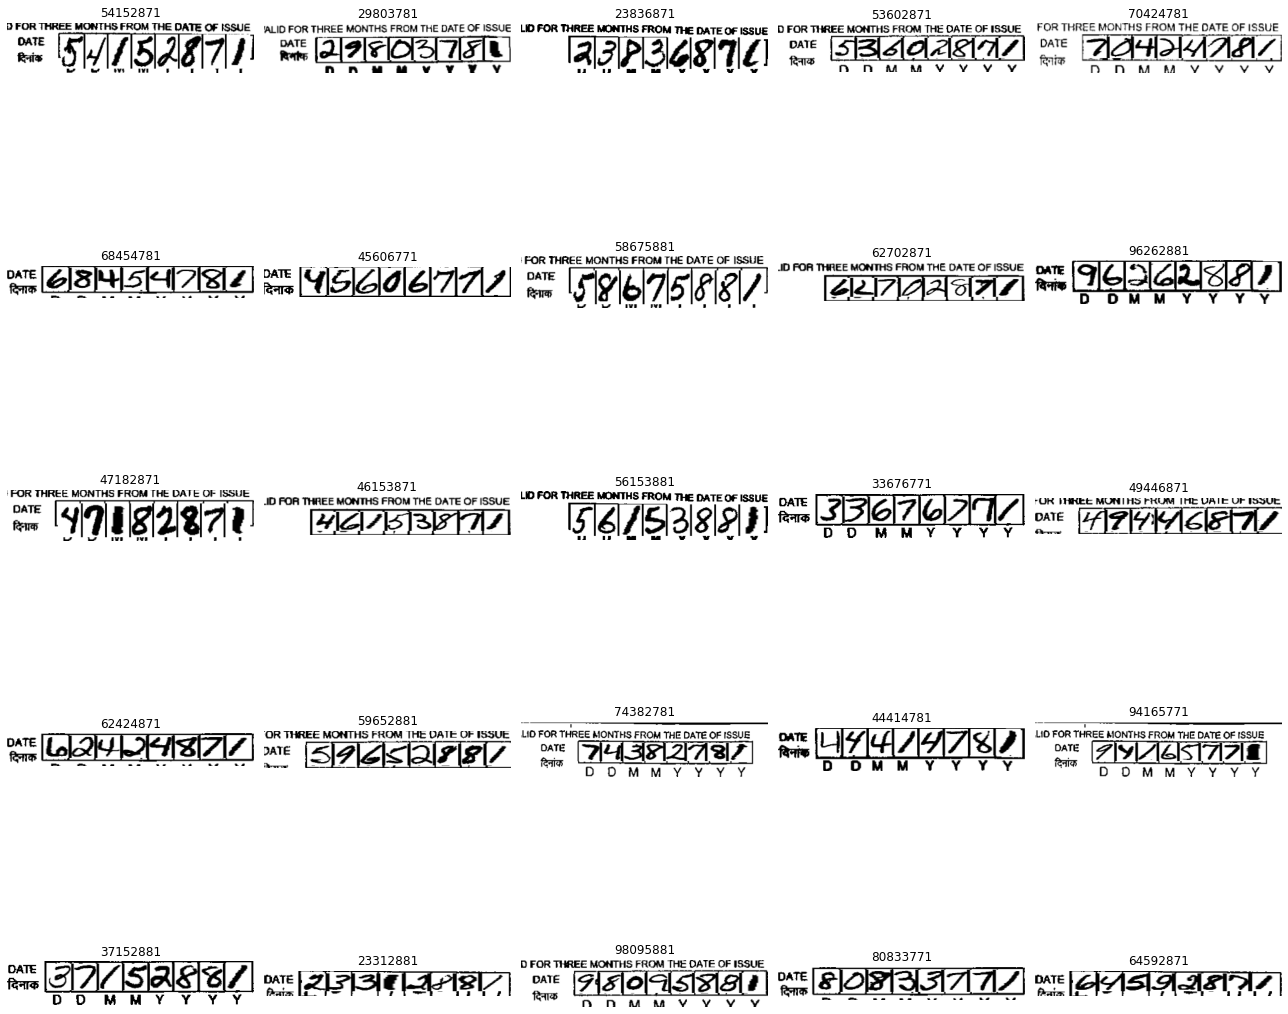

In [24]:
plot_grid(image_paths, orig_labels)

### Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [25]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [26]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 3s 0us/step


### Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk.

In [27]:
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(BATCH_SIZE)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, batch_features.shape[3])
    )

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 141/141 [01:37<00:00,  1.45it/s]


### Preprocess and tokenize the captions

In [28]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [29]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(labels)
train_seqs = tokenizer.texts_to_sequences(labels)

In [30]:
train_seqs = tokenizer.texts_to_sequences(labels)

In [31]:
max_length = calc_max_length(train_seqs)

### Split the data into training and testing

In [32]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, train_seqs):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [33]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(7216, 7216, 1804, 1804)

### Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [34]:
BUFFER_SIZE = 1000
EMBED_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.word_index)+1
EPOCHS = 25
NUM_STEPS = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [35]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8") + ".npy")
    return img_tensor, cap

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(
    lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [37]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [38]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [39]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
encoder = CNN_Encoder(EMBED_DIM)
decoder = RNN_Decoder(EMBED_DIM, UNITS, VOCAB_SIZE)

In [41]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [42]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [44]:
loss_plot = []

In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [46]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 200 == 0:
            print(
                "Epoch {} Batch {} Loss {:.4f}".format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
                )
            )
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / NUM_STEPS)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print("Epoch {} Loss {:.6f}".format(epoch + 1, total_loss / NUM_STEPS))
    print("Time taken for 1 epoch {} sec\n".format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3693
Epoch 1 Loss 1.667085
Time taken for 1 epoch 47.490614891052246 sec

Epoch 2 Batch 0 Loss 1.4627
Epoch 2 Loss 1.399680
Time taken for 1 epoch 28.75749135017395 sec

Epoch 3 Batch 0 Loss 1.3401
Epoch 3 Loss 1.108668
Time taken for 1 epoch 6.791419506072998 sec

Epoch 4 Batch 0 Loss 1.0192
Epoch 4 Loss 0.936957
Time taken for 1 epoch 6.784895181655884 sec

Epoch 5 Batch 0 Loss 0.8731
Epoch 5 Loss 0.834125
Time taken for 1 epoch 6.769026041030884 sec

Epoch 6 Batch 0 Loss 0.8006
Epoch 6 Loss 0.750494
Time taken for 1 epoch 6.971811294555664 sec

Epoch 7 Batch 0 Loss 0.6969
Epoch 7 Loss 0.690814
Time taken for 1 epoch 6.7580626010894775 sec

Epoch 8 Batch 0 Loss 0.6900
Epoch 8 Loss 0.642680
Time taken for 1 epoch 6.937384605407715 sec

Epoch 9 Batch 0 Loss 0.6273
Epoch 9 Loss 0.604517
Time taken for 1 epoch 6.9349071979522705 sec

Epoch 10 Batch 0 Loss 0.5737
Epoch 10 Loss 0.563464
Time taken for 1 epoch 6.933644533157349 sec

Epoch 11 Batch 0 Loss 0.5700
Epoch 

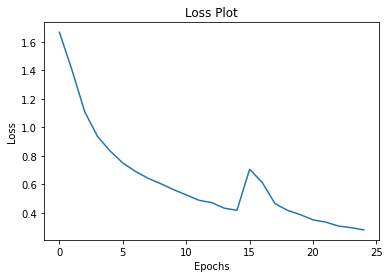

In [47]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()

## Evaluation

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [93]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == "<end>":
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[: len(result), :]
    return result, attention_plot

**Greedy Search**

In [94]:
def evaluate_greedy(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims(
        [tokenizer.word_index["<start>"]], 0
    )  # Start token is <start> for LSTM
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(
            tokenizer.index_word[predicted_id]
        )  # Store the result or word predicted

        if (
            tokenizer.index_word[predicted_id] == "<end>"
        ):  # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims(
            [predicted_id], 0
        )  # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[: len(result), :]
    return result, attention_plot

In [97]:
def plot_attention(image, result, attention_plot, title=""):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap="gray", alpha=0.6, extent=img.get_extent())

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

Real Caption: <start> 6 6 2 3 5 7 7 1 <end>
Prediction Caption: 6 6 2 6 2 7 7 1 <end>


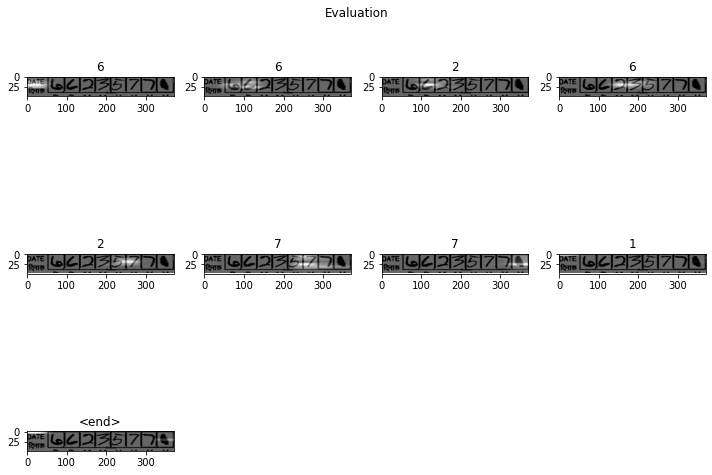

Real Caption: <start> 9 1 3 6 2 7 7 1 <end>
Prediction Caption: 9 9 2 2 2 7 7 1 <end>


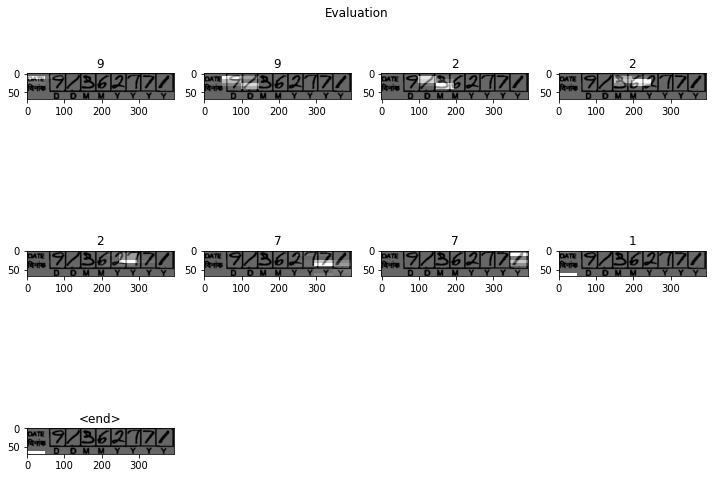

Real Caption: <start> 8 9 9 2 2 8 7 1 <end>
Prediction Caption: 7 9 9 8 4 7 8 1 <end>


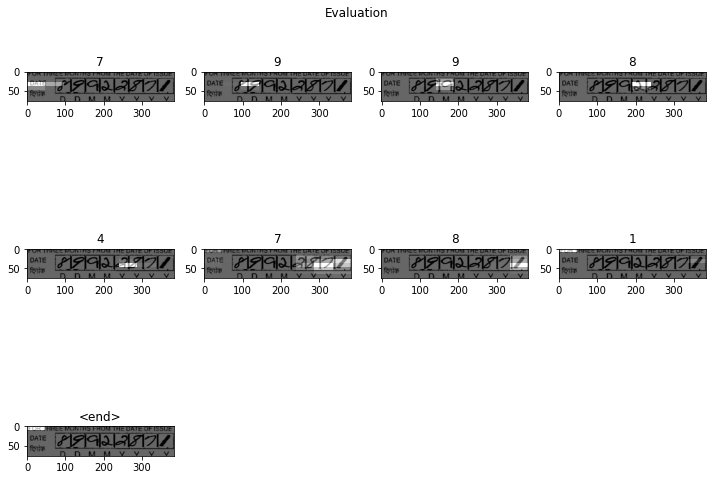

In [98]:
# captions on the validation set
for _ in range(3):
    rid = np.random.randint(0, 100)
    image = img_name_val[rid]
    real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    print("Real Caption:", real_caption)
    print("Prediction Caption:", " ".join(result))
    plot_attention(image, result, attention_plot, title="Evaluation")

Real Caption: <start> 8 9 9 2 2 8 7 1 <end>
Prediction Caption: 7 9 9 8 4 7 7 1 <end>


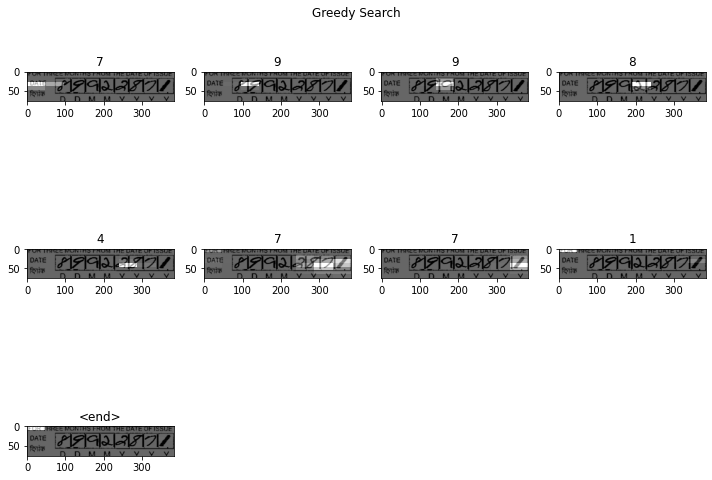

Real Caption: <start> 2 3 4 3 4 8 8 1 <end>
Prediction Caption: 5 3 3 3 3 7 8 1 <end>


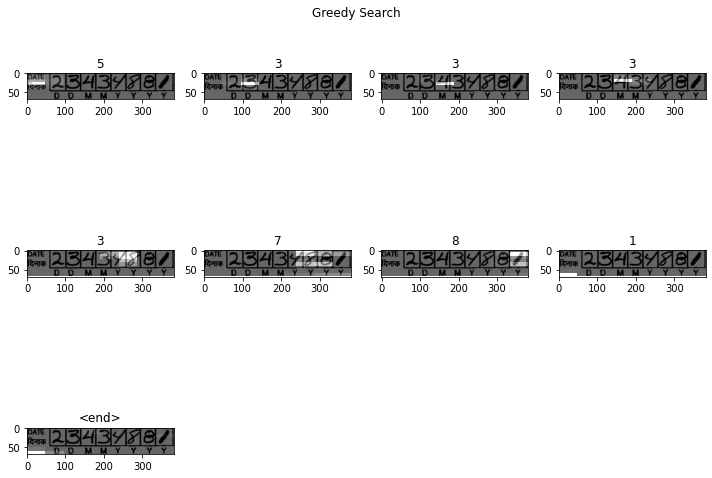

Real Caption: <start> 8 9 9 2 2 8 7 1 <end>
Prediction Caption: 7 9 9 8 4 7 7 1 <end>


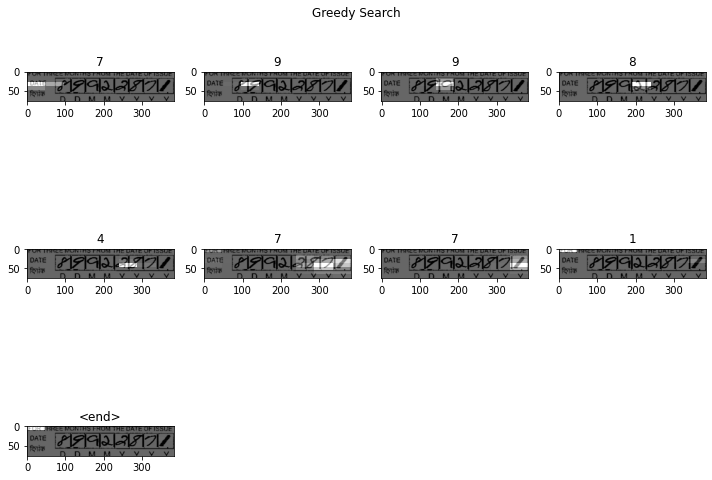

In [99]:
# captions on the validation set
for _ in range(3):
    rid = np.random.randint(0, 100)
    image = img_name_val[rid]
    real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate_greedy(image)

    print("Real Caption:", real_caption)
    print("Prediction Caption:", " ".join(result))
    plot_attention(image, result, attention_plot, title="Greedy Search")

### Validation Data Evaluation

**Normal Evaluation**

In [103]:
count = 0
val_preds, val_matches = [], []

for idx in tqdm(range(len(img_name_val))):
    result, _ = evaluate(img_name_val[idx])
    result = "".join(result[:-1])
    label = "".join([tokenizer.index_word[i] for i in cap_val[idx][1:-1] if i not in [0]])
    val_preds.append(result)

    if len(result) < 8:
        count += 1
    else:
        digit_matches = {}
        for j in range(8):
            digit_matches[j] = result[j]==label[j]
        val_matches.append(digit_matches)

100%|██████████| 1804/1804 [04:22<00:00,  6.88it/s]


In [104]:
result_df = pd.DataFrame(val_matches)
valid_res = pd.DataFrame()
valid_res["# Positionwise Correct Preds"] = result_df.sum()
valid_res["% Positionwise Accuracy"] = result_df.sum()/len(result_df)*100

In [105]:
print("Validation Data Evaluation")
valid_res

Validation Data Evaluation


,# Positionwise Correct Preds,% Positionwise Accuracy
0,1262,70.859068
1,830,46.603032
2,731,41.044357
3,722,40.539023
4,1033,58.001123
5,1504,84.446940
6,1614,90.623245
7,1765,99.101628


**The entire training data has either [771, 781, 871, 881] as the last 3 digit. On the other hand this is not the case with testing data. Refer my [exploration notebook](initial_exploration.ipynb)**

**Greedy Evaluation**

In [106]:
count = 0
val_preds, val_matches = [], []

for idx in tqdm(range(len(img_name_val))):
    result, _ = evaluate_greedy(img_name_val[idx])
    result = "".join(result[:-1])
    label = "".join([tokenizer.index_word[i] for i in cap_val[idx][1:-1] if i not in [0]])
    val_preds.append(result)

    if len(result) < 8:
        count += 1
    else:
        digit_matches = {}
        for j in range(8):
            digit_matches[j] = result[j]==label[j]
        val_matches.append(digit_matches)

100%|██████████| 1804/1804 [04:18<00:00,  6.97it/s]


In [107]:
result_df = pd.DataFrame(val_matches)
valid_res = pd.DataFrame()
valid_res["# Positionwise Correct Preds"] = result_df.sum()
valid_res["% Positionwise Accuracy"] = result_df.sum()/len(result_df)*100

In [108]:
print("Validation Data Evaluation (Greedy Search)")
valid_res

Validation Data Evaluation (Greedy Search)


,# Positionwise Correct Preds,% Positionwise Accuracy
0,1289,72.132065
1,903,50.531617
2,792,44.320090
3,801,44.823727
4,1112,62.227196
5,1528,85.506435
6,1651,92.389480
7,1779,99.552322


### Entire Training Data Evaluation

In [126]:
def evaluate_training_data(greedy=False):
    count = 0
    train_preds, train_matches, train_mismatches, train_all_preds = [], [], [], []
    for path, label in tqdm(dict(zip(image_paths, orig_labels)).items()):
        try:
            if greedy:
                result, attention_plot = evaluate_greedy(path)
            else:
                result, attention_plot = evaluate(path)
            result = "".join(result[:-1])
            train_preds.append(result)

            train_all_preds.append({path: result})

            if len(result) < 8:
                count += 1
                train_mismatches.append({path: result})
            else:
                digit_matches = {}
                for j in range(8):
                    digit_matches[j] = result[j]==label[j]
                train_matches.append(digit_matches)
        except Exception:
            count += 1

    result_df = pd.DataFrame(train_matches)
    train_res = pd.DataFrame()
    train_res["# Positionwise Correct Preds"] = result_df.sum()
    train_res["% Positionwise Accuracy"] = result_df.sum()/len(result_df)*100
    print(train_res)
    train_all_preds = pd.DataFrame(train_all_preds)
    return train_all_preds

In [127]:
train_all_preds = evaluate_training_data()
train_all_preds.to_csv("train_results.csv", index=False)


   # Positionwise Correct Preds  % Positionwise Accuracy
0                          7833                87.266043
1                          6134                68.337790
2                          5327                59.347148
3                          5222                58.177362
4                          6355                70.799911
5                          8120                90.463458
6                          8537                95.109180
7                          8946                99.665775


**Greedy Search**

In [128]:
train_all_preds = evaluate_training_data(greedy=True)
train_all_preds.to_csv("train_results_greedy.csv", index=False)


   # Positionwise Correct Preds  % Positionwise Accuracy
0                          8108                90.319706
1                          6898                76.840815
2                          6195                69.009691
3                          6101                67.962571
4                          6981                77.765400
5                          8372                93.260555
6                          8676                96.646987
7                          8963                99.844046


### Test Data Prediction

In [116]:
# prediction on test set
def evaluate_test_data(greedy=False):
    test_image_paths = [f"processed/test/{x}.png" for x in range(1000)]
    preds = []
    for path in tqdm(test_image_paths):
        if greedy:
            result, _ = evaluate_greedy(path)
        else:
            result, _ = evaluate(path)
        result = "".join(result[:-1])
        preds.append(result)
    return preds

In [117]:
test_image_paths = [f"processed/test/{x}.png" for x in range(1000)]
preds = evaluate_test_data()
greedy_preds = evaluate_test_data(greedy=True)

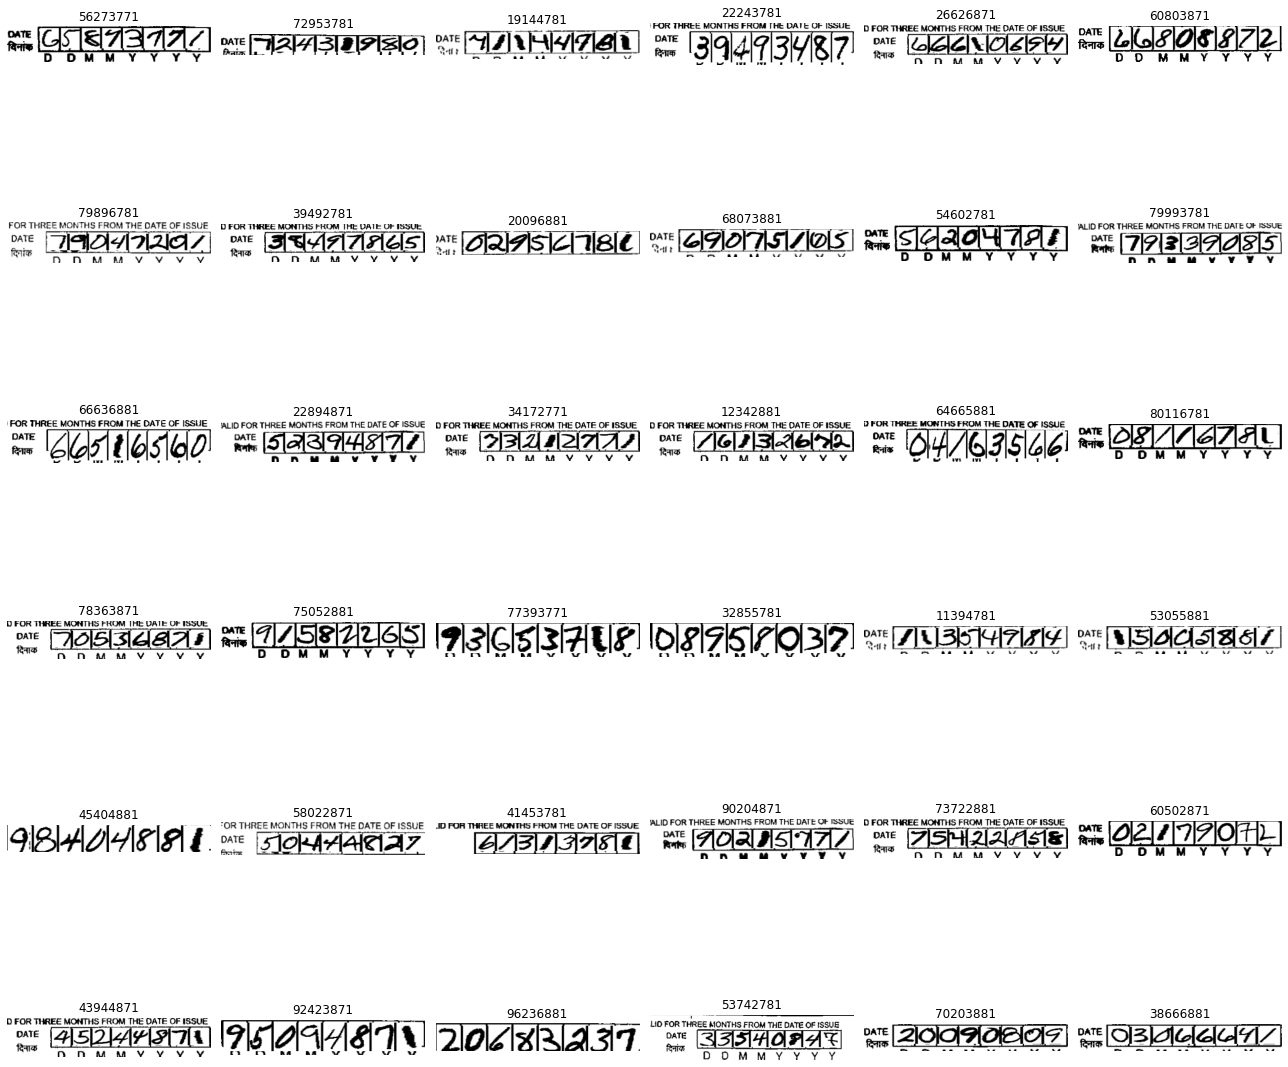

In [118]:
plot_grid(test_image_paths, preds, h=6, w=6)

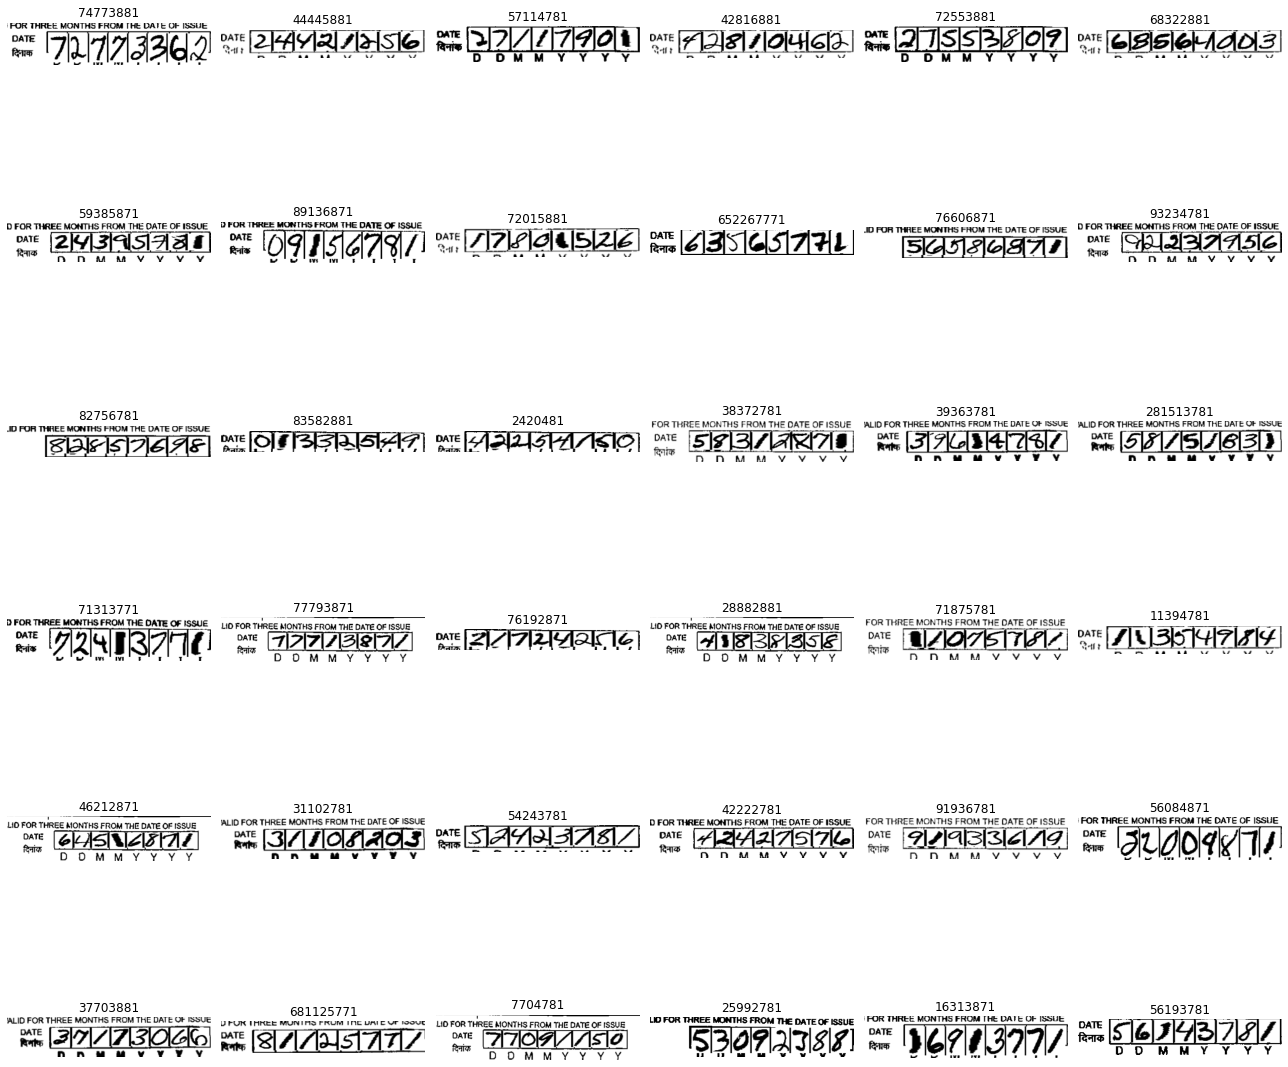

In [119]:
plot_grid(test_image_paths, greedy_preds, h=6, w=6)

In [120]:
def get_submission_csv(preds):
    sub_df = pd.DataFrame()
    sub_df["tag"] = np.arange(0, 1000)
    sub_df["label"] = preds
    sub_df.to_csv(f"submission_image_captioning.csv", index=False)

    # aligning tags
    sample = pd.read_csv("raw/test_data/sample_submission.csv")
    sub_df = sub_df.set_index("tag")
    sub_df = sub_df.reindex(index=sample["tag"])
    sub_df = sub_df.reset_index()
    return sub_df

In [121]:
sub = get_submission_csv(preds)
greedy_sub = get_submission_csv(greedy_preds)

In [122]:
sub_json = greedy_sub.to_json()
data = {
    "username": "aditya",
    "password": "sdhjbj@8676",
    "submission": sub_json,
    "tag": "aditya_test",
}
r = requests.post(SUBMISSION_URL, json=data)

In [123]:
r.text

'{"success":false,"error_message":"name \'acc\' is not defined"}'

In [130]:
sub.to_csv("test_results.csv", index=False)
greedy_sub.to_csv("test_results_greedy.csv", index=False)

In [ ]:
!tar -cf checkpoints.tar checkpoints